In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from numpy import *

##
# Read the different types of input
##

def readBitSeqFiles(trFile, alphaFile, suffix):
    tr = pd.read_table(trFile, comment='#', sep='\s+',
                       names = ['Gene{}'.format(suffix), 
                                'Name', 
                                'Length{}'.format(suffix), 
                                'EffLen{}'.format(suffix)])
    #tr.set_index('Name', inplace=True)
    alphas = pd.read_table(alphaFile, sep='\s+',comment='#',
                     names = ['mean_theta{}'.format(suffix),
                              'alpha{}'.format(suffix),
                              'beta{}'.format(suffix)])
    # The first row is the "noise" transcript
    noise = alphas.ix[0]
    alphas = alphas.ix[1:]
    alphas.index -= 1
    df = tr.join(alphas)
    df.set_index('Name', inplace=True)
    df.convert_objects(convert_numeric=True)
    return noise, df 


def readRSEMTruth(fn, suffix=""):
    df = pd.read_csv(fn, sep='\t', skiprows=1,
                     names=['Name', 'Gene{}'.format(suffix),
                            'Length{}'.format(suffix),
                            'EffLength{}'.format(suffix),
                            'Count{}'.format(suffix),
                            'TPM{}'.format(suffix),
                            'FPKM{}'.format(suffix),
                            'IsoPct{}'.format(suffix)])
    df.set_index('Name', inplace=True)
    return df


def readProFile(fn, suffix=""):
    df = pd.read_csv(fn, sep='\t',
                     names=['Locus{}'.format(suffix),
                            'Name',
                            'Coding{}'.format(suffix),
                            'Length{}'.format(suffix),
                            'ExpFrac{}'.format(suffix),
                            'ExpNum{}'.format(suffix),
                            'LibFrac{}'.format(suffix),
                            'LibNum{}'.format(suffix),
                            'SeqFrac{}'.format(suffix),
                            'SeqNum{}'.format(suffix),
                            'CovFrac{}'.format(suffix),
                            'ChiSquare{}'.format(suffix),
                            'CV{}'.format(suffix)])
    df.set_index('Name', inplace=True)
    df.convert_objects(convert_numeric=True)
    return df

def readSailfishQuasi(fn, suffix=""):
    df = pd.read_table(fn, sep='\t', comment='#',
                     names=['Name',
                            'Length{}'.format(suffix),
                            'TPM{}'.format(suffix),
                            'NumReads{}'.format(suffix)])
    df.dropna(how='all', inplace=True)
    df.convert_objects(convert_numeric=True)
    df.set_index('Name', inplace=True)
    return df

def readKallisto(fn, suffix=""):
    df = pd.read_csv(fn, sep='\t', skiprows=1,
                     names=['Name',
                            'Length{}'.format(suffix),
                            'EffLen{}'.format(suffix),
                            'NumReads{}'.format(suffix),
                            'TPM{}'.format(suffix)])
    df.set_index('Name', inplace=True)
    df.convert_objects(convert_numeric=True)
    return df

def readBitSeqFileOld(fn,suffix):
    df = pd.read_table(fn, sep='\s*',comment='#',
                     names = ['Name',
                              'Length_{}'.format(suffix),
                              'mean_theta{}'.format(suffix),
                              'alpha{}'.format(suffix),
                              'beta{}'.format(suffix)])
    df.set_index('Name', inplace=True)
    df.convert_objects(convert_numeric=True)
    return df 


v = 'TPM_norm'

## Load the flux simulator results

In [17]:
fluxTruth = readProFile("/mnt/scratch3/avi/Analysis/data/FluxSim/config.pro","_truth")
sailfishFluxEM = readSailfishQuasi('/mnt/scratch3/avi/Analysis/data/sailfish/flux/quant/quant.sf',"_sailfish")
kallistoFlux = readKallisto('/mnt/scratch3/avi/Analysis/data/kallisto/flux/quant/abundance.tsv','_kallisto')
noise, BitseqVB = readBitSeqFiles('/mnt/scratch3/avi/Analysis/data/bitseq/flux/parse/ensemblGenes.tr', '/mnt/scratch3/avi/Analysis/data/bitseq/flux/quant/quant.m_alphas','_BVB')

Compute ground truth values for the flux simulator data in terms of TPM

In [18]:
fluxTruth['TPM_truth'] = fluxTruth['ExpFrac_truth'] * 1000000

Join the data frames together based on the transcript names

In [19]:
m = fluxTruth.join(sailfishFluxEM).join(kallistoFlux).join(BitseqVB)

In [20]:
# BVB2 is how this is computed in the R code
m['mean_theta_BVB'] = m['mean_theta_BVB']  / (1.0 - noise['mean_theta_BVB']) 
m['TPM_BVB2'] = m['mean_theta_BVB'] / m['EffLen_BVB']
m['TPM_BVB2'] = m['TPM_BVB2'] / m['TPM_BVB2'].sum()
m['TPM_BVB2'] *= 1000000

In [21]:
rdict = {}

eps = 1.0
corrSFSpear = m['TPM_truth'].corr(m['TPM_sailfish'], 'spearman')
corrSFPearson = m['TPM_truth'].corr(m['TPM_sailfish'])
corrSFPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_sailfish']+eps))

corrKalSpear = m['TPM_truth'].corr(m['TPM_kallisto'], 'spearman')
corrKalPearson = m['TPM_truth'].corr(m['TPM_kallisto'])
corrKalPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_kallisto']+eps))


corrBVBSpear = m['TPM_truth'].corr(m['TPM_BVB2'], 'spearman')
corrBVBPearson = m['TPM_truth'].corr(m['TPM_BVB2'], 'spearman')
corrBVBPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_BVB2']+eps))


print("Spearman Correlation\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFSpear, corrKalSpear, corrBVBSpear))
print("\nPearson Correlation\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFPearson, corrKalPearson, corrBVBPearson))
print("\nPearson Correlation (log scale)\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFPearsonLog, corrKalPearsonLog, corrBVBPearsonLog))

Spearman Correlation
Sailfish (quasi) = 0.722497066812
Kallisto = 0.708092403479
BitSeqVB = 0.402206420555

Pearson Correlation
Sailfish (quasi) = 0.661514201258
Kallisto = 0.0468093904566
BitSeqVB = 0.402206420555

Pearson Correlation (log scale)
Sailfish (quasi) = 0.900789574899
Kallisto = 0.90909357467
BitSeqVB = 0.780811925345


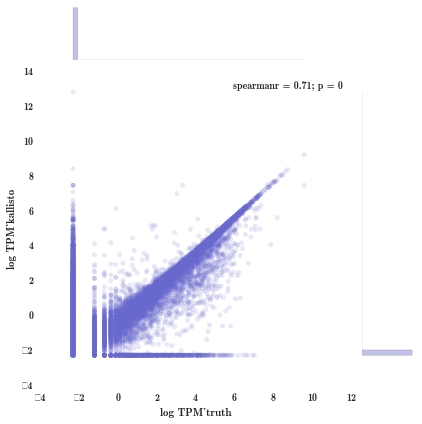

In [22]:
%matplotlib inline
import numpy as np
from scipy.stats import spearmanr
m['log TPM_truth'] = m['TPM_truth']
m['log TPM_kallisto'] = m['TPM_kallisto']
sns.jointplot(np.log(m['log TPM_truth']+0.1), np.log(m['log TPM_kallisto']+0.1), stat_func=spearmanr, color=(0.4, 0.4, 0.8, 0.15))

##Now we consider some MAE-related metrics

First, with a pseudo-count

In [64]:
m['truth_log'] = log(m['TPM_truth']/sum(m['TPM_truth']))
m['test_log_sf'] = log(m['TPM_sailfish']/sum(m['TPM_sailfish']))
m['test_log_kallisto'] = log(m['TPM_kallisto']/sum(m['TPM_kallisto']))
m['test_log_bvb'] = log(m['TPM_BVB2']/sum(m['TPM_BVB2']))

In [65]:
indsSF = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']))
indsK = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_kallisto']))
indsBVB = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_bvb']))
indsAll = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']) & np.isfinite(m['test_log_kallisto']) & np.isfinite(m['test_log_bvb']))

eps = 1.0
m['TPM_truth_pseudo'] = m['TPM_truth'] + eps
m['TPM_sf_pseudo'] = m['TPM_sailfish'] + eps
m['TPM_kallisto_pseudo'] = m['TPM_kallisto'] + eps
m['TPM_bvb_pseudo'] = m['TPM_BVB2'] + eps
m['truth_log_pseudo'] = log(m['TPM_truth_pseudo']/sum(m['TPM_truth_pseudo']))
m['test_log_sf_pseudo'] = log(m['TPM_sf_pseudo']/sum(m['TPM_sf_pseudo']))
m['test_log_kal_pseudo'] = log(m['TPM_kallisto_pseudo']/sum(m['TPM_kallisto_pseudo']))
m['test_log_bvb_pseudo'] = log(m['TPM_bvb_pseudo']/sum(m['TPM_bvb_pseudo']))

resSFPseudo = (m['truth_log_pseudo'] - m['test_log_sf_pseudo']).abs().mean()
resKPseudo= (m['truth_log_pseudo'] - m['test_log_kal_pseudo']).abs().mean()
resBVBPseudo = (m['truth_log_pseudo'] - m['test_log_bvb_pseudo']).abs().mean()
print("MAE where TPMs are given a pseudocount (1.0)\n================================================")
print("MAE (Sailfish) = {}\nMAE (Kallisto) = {}\nMAE (BitseqVB) = {}".format(\
                    resSFPseudo, resKPseudo, resBVBPseudo))

MAE where TPMs are given a pseudocount (1.0)
MAE (Sailfish) = 0.110811890107
MAE (Kallisto) = 0.112193639394
MAE (BitseqVB) = 0.227895551619


Now, discarding transcripts not detected by each method 

In [66]:
resSF = (m['truth_log'][indsSF] - m['test_log_sf'][indsSF]).abs().mean()
resK= (m['truth_log'][indsK] - m['test_log_kallisto'][indsK]).abs().mean()
resBVB = (m['truth_log'][indsBVB] - m['test_log_bvb'][indsBVB]).abs().mean()

print("MAE where infinite log(TPM)s are *excluded*\n==============================================")
print("MAE (Sailfish) = {}; #txps = {}\nMAE (Kallisto) = {}; #txps = {}\nMAE (BitseqVB) = {}; #txps = {}".format(\
                            resSF, len(indsSF[indsSF==True]), \
                            resK, len(indsK[indsK==True]), resBVB, len(indsBVB[indsBVB==True])))

MAE where infinite log(TPM)s are *excluded*
MAE (Sailfish) = 0.561051974339; #txps = 13258
MAE (Kallisto) = 0.790124612524; #txps = 12794
MAE (BitseqVB) = 0.996392973231; #txps = 18948


Finally, discarding transcripts not discovered by *all* methods

In [67]:
indsAll = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']) & np.isfinite(m['test_log_kallisto']) & np.isfinite(m['test_log_bvb'])) 
resSFIgnore = (m['truth_log'][indsAll] - m['test_log_sf'][indsAll]).abs().mean()
resKIgnore = (m['truth_log'][indsAll] - m['test_log_kallisto'][indsAll]).abs().mean()
resBVBIgnore = (m['truth_log'][indsAll] - m['test_log_bvb'][indsAll]).abs().mean()
print("MAE where txps missed by any method are discarded\n================================================")
print("MAE (Sailfish) = {}\nMAE (Kallisto) = {}\nMAE (BitseqVB) = {}".format(\
                        resSFIgnore,  resKIgnore, resBVBIgnore))

MAE where txps missed by any method are discarded
MAE (Sailfish) = 0.519228296651
MAE (Kallisto) = 0.659357056256
MAE (BitseqVB) = 0.518586546486


## Load the RSEM results

In [68]:
RSEMTruth = readRSEMTruth("/mnt/scratch1/simulated_data/rsem_sim_data/11.sim.isoforms.results","_truth")
sailfishRSEM = readSailfishQuasi('/mnt/scratch1/avi/Analysis/data/sailfish/rsem/quant/quant.sf',"_sailfish")
kallistoRSEM = readKallisto('/mnt/scratch1/avi/Analysis/data/kallisto/rsem/quant/abundance.tsv','_kallisto')
noise, BitseqVBRSEM = readBitSeqFiles('/mnt/scratch1/avi/Analysis/data/bitseq/rsem/parse/ensemblGenes.tr', '/mnt/scratch1/avi/Analysis/data/bitseq/rsem/quant/quant.m_alphas','_BVB')

IOError: File /mnt/scratch1/avi/Analysis/data/sailfish/rsem/quant/quant.sf does not exist

Join the data frames together based on the transcript names

In [69]:
m = RSEMTruth.join(sailfishRSEM).join(kallistoRSEM).join(BitseqVBRSEM)

In [70]:
m['TPM_BVB'] = m['alpha_BVB'] / m['Length_truth']
m['TPM_BVB'] = m['TPM_BVB']/sum(m['TPM_BVB'])
m['TPM_BVB'] = m['TPM_BVB']*1000000
m['mean_theta_BVB'] = m['mean_theta_BVB']  / (1.0 - noise['mean_theta_BVB']) 
m['TPM_BVB2'] = m['mean_theta_BVB'] / m['Length_truth']
m['TPM_BVB2'] = m['TPM_BVB2'] / m['TPM_BVB2'].sum()
m['TPM_BVB2'] *= 1000000

In [71]:
rdict = {}

eps = 1.0
corrSFSpear = m['TPM_truth'].corr(m['TPM_sailfish'], 'spearman')
corrSFPearson = m['TPM_truth'].corr(m['TPM_sailfish'])
corrSFPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_sailfish']+eps))

corrKalSpear = m['TPM_truth'].corr(m['TPM_kallisto'], 'spearman')
corrKalPearson = m['TPM_truth'].corr(m['TPM_kallisto'])
corrKalPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_kallisto']+eps))


corrBVBSpear = m['TPM_truth'].corr(m['TPM_BVB2'], 'spearman')
corrBVBPearson = m['TPM_truth'].corr(m['TPM_BVB2'])
corrBVBPearsonLog = np.log(m['TPM_truth']+eps).corr(np.log(m['TPM_BVB']+eps))


print("Spearman Correlation\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFSpear, corrKalSpear, corrBVBSpear))
print("\nPearson Correlation\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFPearson, corrKalPearson, corrBVBPearson))
print("\nPearson Correlation (log scale)\n===================")
print("Sailfish (quasi) = {}\nKallisto = {}\nBitSeqVB = {}".format(corrSFPearsonLog, corrKalPearsonLog, corrBVBPearsonLog))

Spearman Correlation
Sailfish (quasi) = 0.922684485236
Kallisto = 0.915456257111
BitSeqVB = 0.838078557275

Pearson Correlation
Sailfish (quasi) = 0.999290794226
Kallisto = 0.999173138834
BitSeqVB = 0.981274911489

Pearson Correlation (log scale)
Sailfish (quasi) = 0.990801006004
Kallisto = 0.990718221988
BitSeqVB = 0.985633444818


##Now we consider some MAE-related metrics

First, with a pseudo-count

In [72]:
m['truth_log'] = log(m['TPM_truth']/sum(m['TPM_truth']))
m['test_log_sf'] = log(m['TPM_sailfish']/sum(m['TPM_sailfish']))
m['test_log_kallisto'] = log(m['TPM_kallisto']/sum(m['TPM_kallisto']))
m['test_log_bvb'] = log(m['TPM_BVB']/sum(m['TPM_BVB']))

In [73]:
indsSF = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']))
indsK = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_kallisto']))
indsBVB = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_bvb']))
indsAll = (np.isfinite(m['truth_log']) & np.isfinite(m['test_log_sf']) & np.isfinite(m['test_log_kallisto']) & np.isfinite(m['test_log_bvb']))

eps=1.0
m['TPM_truth_pseudo'] = m['TPM_truth'] + eps
m['TPM_sf_pseudo'] = m['TPM_sailfish'] + eps
m['TPM_kallisto_pseudo'] = m['TPM_kallisto'] + eps
m['TPM_bvb_pseudo'] = m['TPM_BVB'] + eps
m['truth_log_pseudo'] = log(m['TPM_truth_pseudo']/sum(m['TPM_truth_pseudo']))
m['test_log_sf_pseudo'] = log(m['TPM_sf_pseudo']/sum(m['TPM_sf_pseudo']))
m['test_log_kal_pseudo'] = log(m['TPM_kallisto_pseudo']/sum(m['TPM_kallisto_pseudo']))
m['test_log_bvb_pseudo'] = log(m['TPM_bvb_pseudo']/sum(m['TPM_bvb_pseudo']))
resSFPseudo = (m['truth_log_pseudo'] - m['test_log_sf_pseudo']).abs().mean()
resKPseudo= (m['truth_log_pseudo'] - m['test_log_kal_pseudo']).abs().mean()
resBVBPseudo = (m['truth_log_pseudo'] - m['test_log_bvb_pseudo']).abs().mean()
print("MAE where TPMs are given a pseudocount (1.0)\n================================================")
print("MAE (Sailfish) = {}\nMAE (Kallisto) = {}\nMAE (BitseqVB) = {}".format(resSFPseudo, resKPseudo, resBVBPseudo))

MAE where TPMs are given a pseudocount (1.0)
MAE (Sailfish) = 0.0554124446265
MAE (Kallisto) = 0.0585696615932
MAE (BitseqVB) = 0.124865912781


Now, discarding transcripts not detected by each method

In [74]:
resSF = (m['truth_log'][indsSF] - m['test_log_sf'][indsSF]).abs().mean()
resK= (m['truth_log'][indsK] - m['test_log_kallisto'][indsK]).abs().mean()
resBVB = (m['truth_log'][indsBVB] - m['test_log_bvb'][indsBVB]).abs().mean()
print("MAE where infinite log(TPM)s are *excluded*\n==============================================")
print("MAE (Sailfish) = {}; #txps = {}\nMAE (Kallisto) = {}; #txps = {}\nMAE (BitseqVB) = {}; #txps = {}".format(\
                            resSF, len(indsSF[indsSF==True]), \
                            resK, len(indsK[indsK==True]), \
                            resBVB, len(indsBVB[indsBVB==True])))

MAE where infinite log(TPM)s are *excluded*
MAE (Sailfish) = 0.215127688677; #txps = 40640
MAE (Kallisto) = 0.352315023198; #txps = 42061
MAE (BitseqVB) = 0.356606720541; #txps = 46708


In [75]:
resSFIgnore = (m['truth_log'][indsAll] - m['test_log_sf'][indsAll]).abs().mean()
resKIgnore = (m['truth_log'][indsAll] - m['test_log_kallisto'][indsAll]).abs().mean()
resBVBIgnore = (m['truth_log'][indsAll] - m['test_log_bvb'][indsAll]).abs().mean()
print("MAE where txps missed by any method are discarded\n================================================")
print("MAE (Sailfish) = {}\nMAE (Kallisto) = {}\nMAE (BitseqVB) = {}".format(\
                        resSFIgnore, resKIgnore, resBVBIgnore))

MAE where txps missed by any method are discarded
MAE (Sailfish) = 0.213985703627
MAE (Kallisto) = 0.226499601065
MAE (BitseqVB) = 0.306732156881
